In [1]:
import sys
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from pathlib import Path
from glob import glob
%precision 3
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor

# use my matplotlib style
# style_p = Path("Z:/Katsuya Shiratori/004_coding/python")
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))
import Lorentzian

## upload data

In [135]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data['ratio'] = glass_data['length'] / glass_data['width']
glass_data = glass_data.drop(['corrcoef'], axis=1)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

# define input and output
X_glass = glass_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_glass = glass_data['width']
yl_glass = glass_data['length']

# define input and output
X_ito = ito_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_ito = ito_data['width']
yl_ito = ito_data['length']

In [136]:
# define testing data from actual experiments
exp_glass_data = pd.read_csv(Path(p, '100323_ZJ_exp_glass_final.csv'))
exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
exp_ito_data = exp_ito_data.drop(47)
exp_ito_data = exp_ito_data.reset_index(drop=True)

# create the specific number of data
exp_glass_data = exp_glass_data.sample(50, random_state=4)
exp_ito_data = exp_ito_data.sample(50, random_state=4)

X_exp_glass = exp_glass_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
X_exp_glass['nsub'] = 1.52
yw_exp_glass = exp_glass_data['width']
yl_exp_glass = exp_glass_data['length']

X_exp_ito = exp_ito_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
X_exp_ito['nsub'] = 1.975
yw_exp_ito = exp_ito_data['width']
yl_exp_ito = exp_ito_data['length']

## add refractive index feature and combined training data 

In [137]:
# SPP all data in my paper
original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
original_data['nsub'] = 1.52

# new glass simulated data
glass_data = glass_data.drop(['ratio'], axis=1)
glass_data['nsub'] = 1.52

# new ITO simulated data
ito_data = ito_data.drop(['ratio'], axis=1)
ito_data['nsub'] = 1.975

In [138]:
print(original_data.shape)
print(glass_data.shape)
print(ito_data.shape)

glass_comb_data = pd.concat([glass_data, original_data], axis=0)

# exclude the distribution with longer linwdith
glass_aranged_data = glass_comb_data[(glass_comb_data['width'] > ito_data['width'].min()) & (glass_comb_data['width'] < ito_data['width'].max()) 
                       & (glass_comb_data['length'] > ito_data['length'].min()) & (glass_comb_data['length'] < ito_data['length'].max())]

combined_data = pd.concat([ito_data, glass_aranged_data], axis=0)
print(glass_comb_data.shape)
print(combined_data.shape)

(576, 6)
(1206, 6)
(3292, 6)
(1782, 6)
(4553, 6)


In [139]:
print(f"width mean+std: {glass_comb_data['width'].mean()} +/- {glass_comb_data['width'].std()}")
print(f"length mean+std: {glass_comb_data['length'].mean()} +/- {glass_comb_data['length'].std()}")

print(f"width mean+std: {glass_aranged_data['width'].mean()} +/- {glass_aranged_data['width'].std()}")
print(f"length mean+std: {glass_aranged_data['length'].mean()} +/- {glass_aranged_data['length'].std()}")

print(f"width mean+std: {ito_data['width'].mean()} +/- {ito_data['width'].std()}")
print(f"length mean+std: {ito_data['length'].mean()} +/- {ito_data['length'].std()}")

width mean+std: 30.732956116722786 +/- 11.944205488455408
length mean+std: 88.00986453423121 +/- 17.69733921950879
width mean+std: 29.01504972244251 +/- 2.0374904114785406
length mean+std: 85.26736772402855 +/- 10.132635913690464
width mean+std: 29.441281895504257 +/- 1.7842411542802916
length mean+std: 91.30991190765492 +/- 9.80495980250767


(60.000, 120.000)

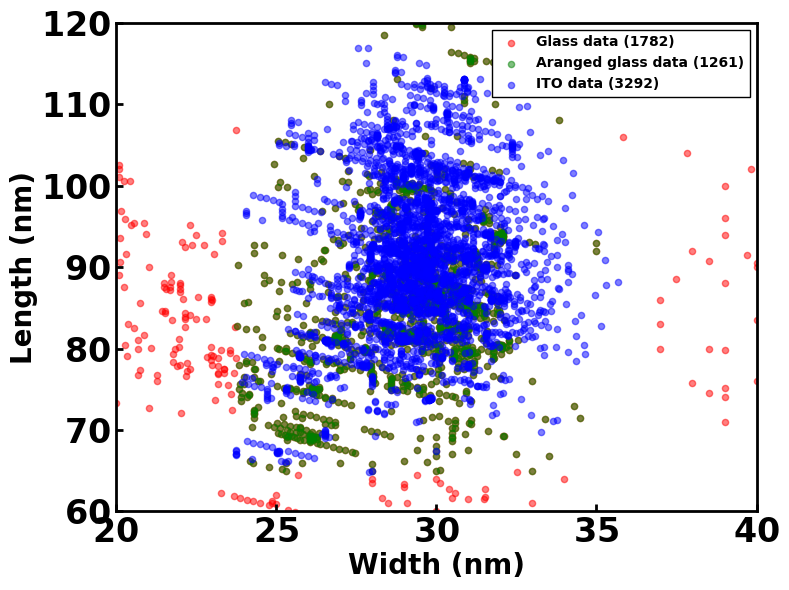

In [140]:
plt.scatter(glass_comb_data['width'], glass_comb_data['length'], c='r', s=20, alpha=.5, label=f'Glass data ({glass_comb_data.shape[0]})')
plt.scatter(glass_aranged_data['width'], glass_aranged_data['length'], c='g', s=20, alpha=.5, label=f'Aranged glass data ({glass_aranged_data.shape[0]})')
plt.scatter(ito_data['width'], ito_data['length'], c='b', s=20, alpha=.5, label=f'ITO data ({ito_data.shape[0]})')
plt.legend()
plt.xlabel('Width (nm)')
plt.ylabel('Length (nm)')

plt.xlim(20, 40)
plt.ylim(60, 120)

width mean+std: 29.01504972244251 +/- 2.0374904114785406
length mean+std: 85.26736772402855 +/- 10.132635913690464
width mean+std: 29.441281895504257 +/- 1.7842411542802916
length mean+std: 91.30991190765492 +/- 9.80495980250767


(60.000, 130.000)

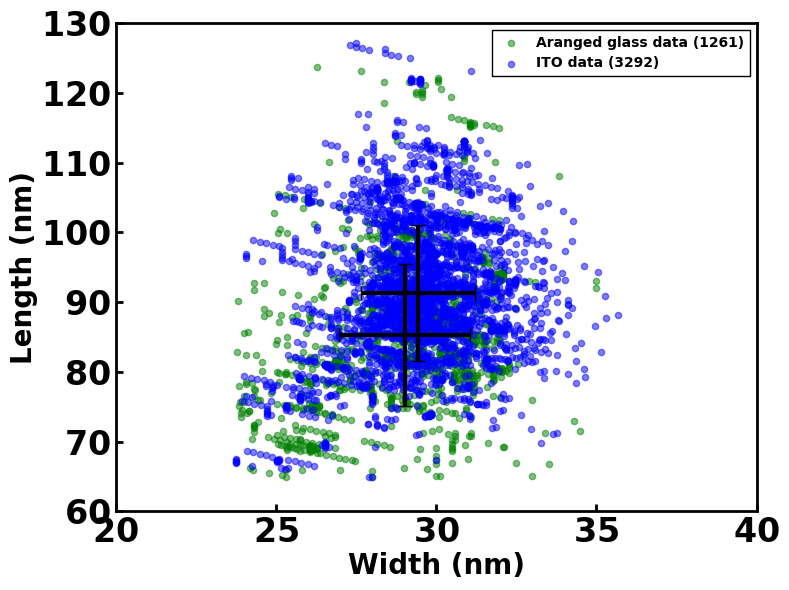

In [189]:
fig, ax = plt.subplots()

ax.scatter(glass_aranged_data['width'], glass_aranged_data['length'], c='g', s=20, alpha=.5, label=f'Aranged glass data ({glass_aranged_data.shape[0]})')
ax.scatter(ito_data['width'], ito_data['length'], c='b', s=20, alpha=.5, label=f'ITO data ({ito_data.shape[0]})')

print(f"width mean+std: {glass_aranged_data['width'].mean()} +/- {glass_aranged_data['width'].std()}")
print(f"length mean+std: {glass_aranged_data['length'].mean()} +/- {glass_aranged_data['length'].std()}")

print(f"width mean+std: {ito_data['width'].mean()} +/- {ito_data['width'].std()}")
print(f"length mean+std: {ito_data['length'].mean()} +/- {ito_data['length'].std()}")

ax.errorbar(ito_data['width'].mean(), ito_data['length'].mean(), 
            xerr=ito_data['width'].std(), yerr=ito_data['length'].std(),
            capsize=5, color='k')

ax.errorbar(glass_aranged_data['width'].mean(), glass_aranged_data['length'].mean(), 
            xerr=glass_aranged_data['width'].std(), yerr=glass_aranged_data['length'].std(),
            capsize=5, color='k')

# ax.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label='Error Bars')

ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.legend()

ax.set_xlabel('Width (nm)')
ax.set_ylabel('Length (nm)')

ax.set_xlim(20, 40)
ax.set_ylim(60, 130)

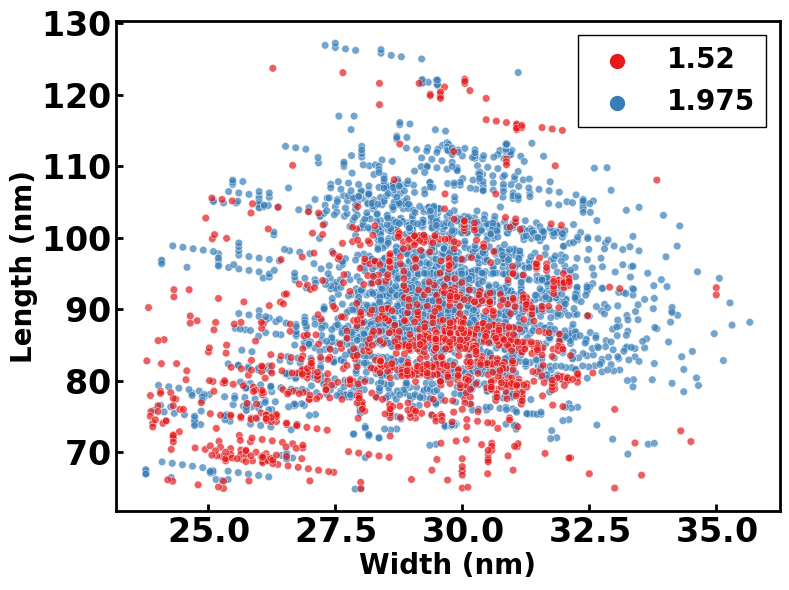

In [176]:
scatter = sns.scatterplot(data=combined_data, x='width', y='length', hue='nsub', s=30, alpha=.7, palette="Set1")
scatter.set_xlabel("Width (nm)")
scatter.set_ylabel("Length (nm)")
scatter.legend(fontsize=20)

In [170]:
combined_data['ratio'] = combined_data['length'] / combined_data['width']

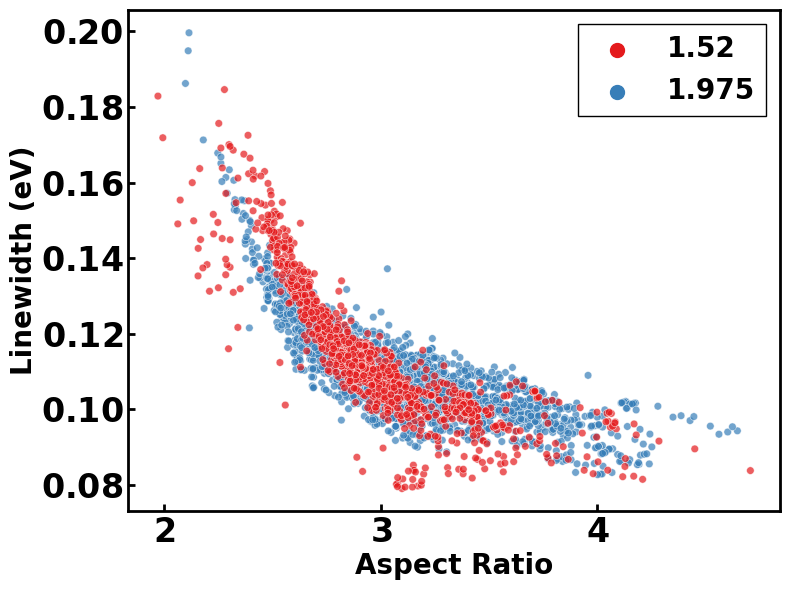

In [173]:
scatter = sns.scatterplot(data=combined_data, x='ratio', y='linewidth', hue='nsub', s=30, alpha=.7, palette="Set1")
scatter.set_xlabel("Aspect Ratio")
scatter.set_ylabel("Linewidth (eV)")
scatter.legend(fontsize=20)

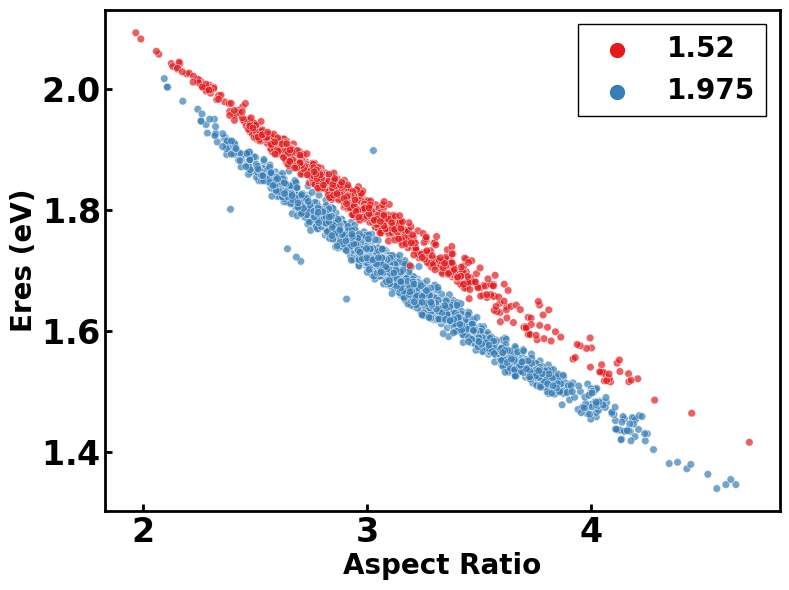

In [174]:
scatter = sns.scatterplot(data=combined_data, x='ratio', y='eres', hue='nsub', s=30, alpha=.7, palette="Set1")
scatter.set_xlabel("Aspect Ratio")
scatter.set_ylabel("Eres (eV)")
scatter.legend(fontsize=20)

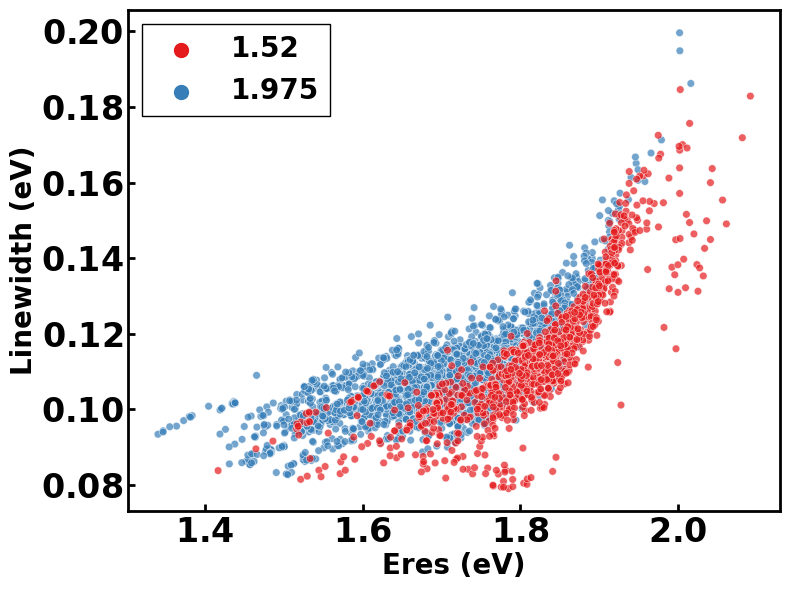

In [175]:
scatter = sns.scatterplot(data=combined_data, x='eres', y='linewidth', hue='nsub', s=30, alpha=.7, palette="Set1")
scatter.set_xlabel("Eres (eV)")
scatter.set_ylabel("Linewidth (eV)")
scatter.legend(fontsize=20)

# Corrected Model Training

In [36]:
# define input and output
X = combined_data.drop(['width', 'length', 'imax'], axis=1)
yw = combined_data['width']
yl = combined_data['length']

## Testing with glass 

In [38]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 11)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X, yw)
yw_pred = gsw.predict(X_exp_glass)

rel_errw = (abs(yw_exp_glass-yw_pred)/yw_exp_glass)*100
rmspew = (sum(rel_errw**2)/len(yw_pred))**0.5

maew = mean_absolute_error(yw_exp_glass, yw_pred)
# msew = mean_squared_error(yw_exp, yw_pred)
# rmsew = np.sqrt(msew)

# Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.2, random_state=0)
# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X, yl)
yl_pred = gsl.predict(X_exp_glass)

rel_errl = (abs(yl_exp_glass-yl_pred)/yl_exp_glass)*100
rmspel = (sum(rel_errl**2)/len(yl_pred)) ** 0.5
mael = mean_absolute_error(yl_exp_glass, yl_pred)

# msel = mean_squared_error(yl_exp, yl_pred)
# rmsel = np.sqrt(msel)

print(rmspew, rmspel)
print(maew, mael)

8.812811371678682 11.77285539048279
2.00576127788125 9.14712246514853


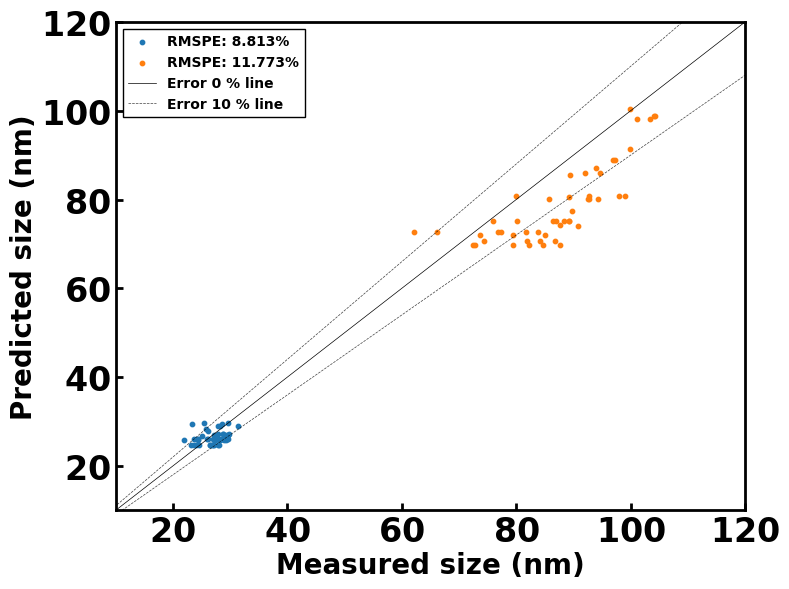

In [40]:
plt.scatter(yw_exp_glass, yw_pred, s=10, label=f'RMSPE: {round(rmspew, 3)}%')
plt.scatter(yl_exp_glass, yl_pred, s=10, label=f'RMSPE: {round(rmspel, 3)}%')

x = np.arange(-1, 181)
plt.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
plt.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
plt.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

plt.xlim(10, 120)
plt.ylim(10, 120)

plt.xlabel("Measured size (nm)")
plt.ylabel("Predicted size (nm)")
plt.legend()

## Testing with ITO

In [41]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 11)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X, yw)
yw_pred = gsw.predict(X_exp_ito)

rel_errw = (abs(yw_exp_ito-yw_pred)/yw_exp_ito)*100
rmspew = (sum(rel_errw**2)/len(yw_pred))**0.5

maew = mean_absolute_error(yw_exp_ito, yw_pred)
# msew = mean_squared_error(yw_exp, yw_pred)
# rmsew = np.sqrt(msew)

# Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.2, random_state=0)
# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X, yl)
yl_pred = gsl.predict(X_exp_ito)

rel_errl = (abs(yl_exp_ito-yl_pred)/yl_exp_ito)*100
rmspel = (sum(rel_errl**2)/len(yl_pred)) ** 0.5
mael = mean_absolute_error(yl_exp_ito, yl_pred)

# msel = mean_squared_error(yl_exp, yl_pred)
# rmsel = np.sqrt(msel)

print(rmspew, rmspel)
print(maew, mael)

10.499915202287548 7.381738436330089
2.4821016131477593 5.261023317461902


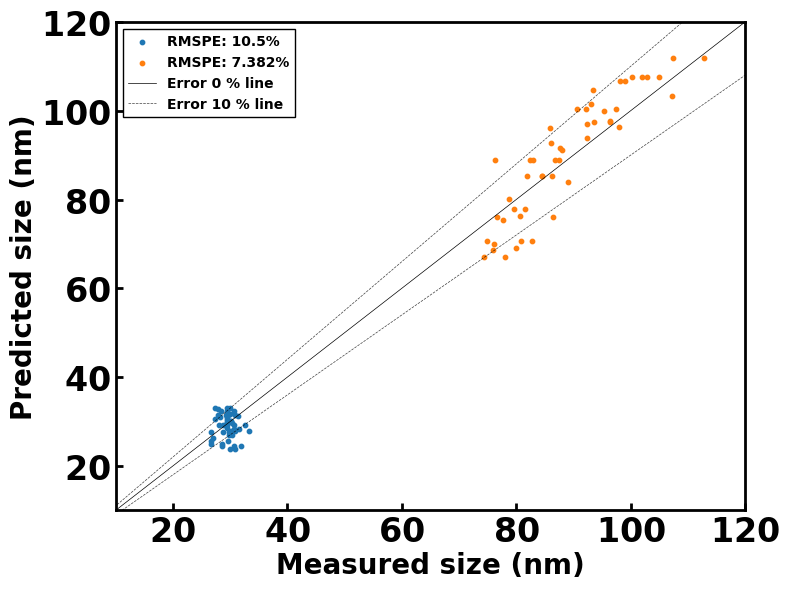

In [42]:
plt.scatter(yw_exp_ito, yw_pred, s=10, label=f'RMSPE: {round(rmspew, 3)}%')
plt.scatter(yl_exp_ito, yl_pred, s=10, label=f'RMSPE: {round(rmspel, 3)}%')

x = np.arange(-1, 181)
plt.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
plt.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
plt.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

plt.xlim(10, 120)
plt.ylim(10, 120)

plt.xlabel("Measured size (nm)")
plt.ylabel("Predicted size (nm)")
plt.legend()

# Just Combined Model Training

In [6]:
# define input and output
X = combined_data.drop(['width', 'length', 'imax', 'nsub'], axis=1)
yw = combined_data['width']
yl = combined_data['length']

In [7]:
X_exp_glass = X_exp_glass.drop(['nsub'], axis=1)
X_exp_ito = X_exp_ito.drop(['nsub'], axis=1)

## Testing with glass

In [8]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 11)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X, yw)
yw_pred = gsw.predict(X_exp_glass)

rel_errw = (abs(yw_exp_glass-yw_pred)/yw_exp_glass)*100
rmspew = (sum(rel_errw**2)/len(yw_pred))**0.5

maew = mean_absolute_error(yw_exp_glass, yw_pred)
# msew = mean_squared_error(yw_exp, yw_pred)
# rmsew = np.sqrt(msew)

# Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.2, random_state=0)
# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X, yl)
yl_pred = gsl.predict(X_exp_glass)

rel_errl = (abs(yl_exp_glass-yl_pred)/yl_exp_glass)*100
rmspel = (sum(rel_errl**2)/len(yl_pred)) ** 0.5
mael = mean_absolute_error(yl_exp_glass, yl_pred)

# msel = mean_squared_error(yl_exp, yl_pred)
# rmsel = np.sqrt(msel)

print(rmspew, rmspel)
print(maew, mael)

9.71585238772524 13.556726208913913
2.3096118141425204 11.01980916673769


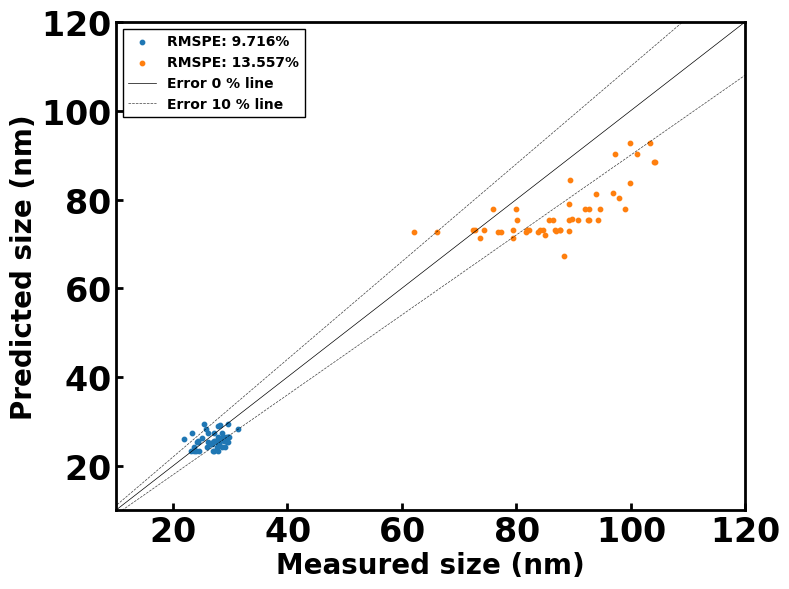

In [9]:
plt.scatter(yw_exp_glass, yw_pred, s=10, label=f'RMSPE: {round(rmspew, 3)}%')
plt.scatter(yl_exp_glass, yl_pred, s=10, label=f'RMSPE: {round(rmspel, 3)}%')

x = np.arange(-1, 181)
plt.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
plt.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
plt.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

plt.xlim(10, 120)
plt.ylim(10, 120)

plt.xlabel("Measured size (nm)")
plt.ylabel("Predicted size (nm)")
plt.legend()

## Testing with ITO

In [10]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 11)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X, yw)
yw_pred = gsw.predict(X_exp_ito)

rel_errw = (abs(yw_exp_ito-yw_pred)/yw_exp_ito)*100
rmspew = (sum(rel_errw**2)/len(yw_pred))**0.5

maew = mean_absolute_error(yw_exp_ito, yw_pred)
# msew = mean_squared_error(yw_exp, yw_pred)
# rmsew = np.sqrt(msew)

# Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.2, random_state=0)
# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X, yl)
yl_pred = gsl.predict(X_exp_ito)

rel_errl = (abs(yl_exp_ito-yl_pred)/yl_exp_ito)*100
rmspel = (sum(rel_errl**2)/len(yl_pred)) ** 0.5
mael = mean_absolute_error(yl_exp_ito, yl_pred)

# msel = mean_squared_error(yl_exp, yl_pred)
# rmsel = np.sqrt(msel)

print(rmspew, rmspel)
print(maew, mael)

8.844630107390767 6.374107535333552
2.111155236582125 4.607587744048414


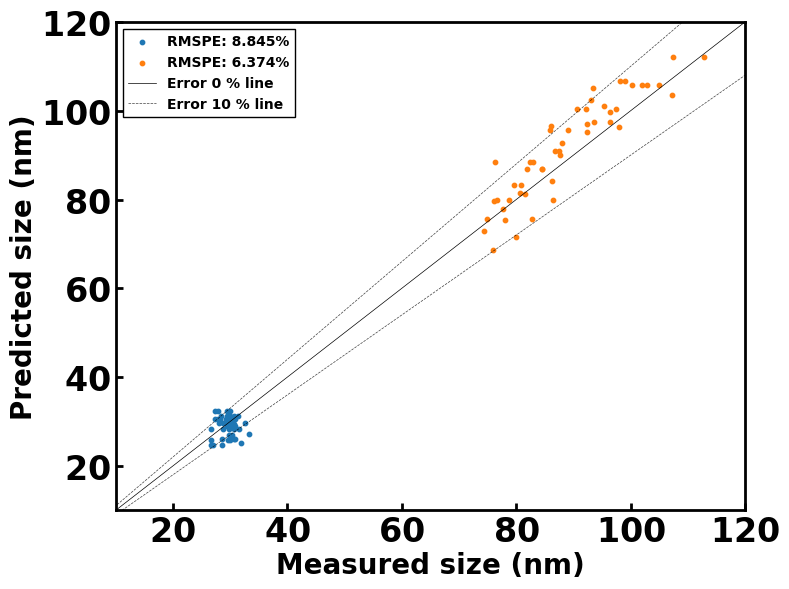

In [11]:
plt.scatter(yw_exp_ito, yw_pred, s=10, label=f'RMSPE: {round(rmspew, 3)}%')
plt.scatter(yl_exp_ito, yl_pred, s=10, label=f'RMSPE: {round(rmspel, 3)}%')

x = np.arange(-1, 181)
plt.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
plt.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
plt.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

plt.xlim(10, 120)
plt.ylim(10, 120)

plt.xlabel("Measured size (nm)")
plt.ylabel("Predicted size (nm)")
plt.legend()